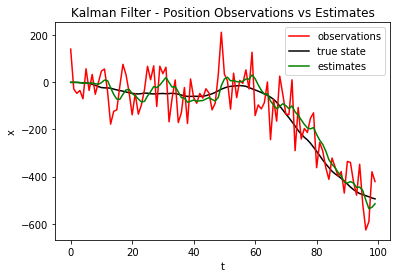

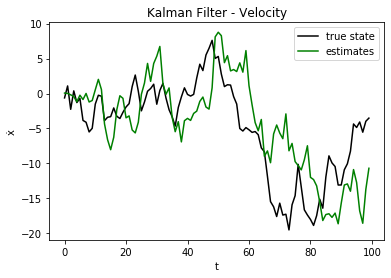

In [4]:
from numpy import identity
from numpy.linalg import inv

import numpy as np

import matplotlib.pyplot as plt


class KalmanFilter:
    def __init__(self, state_estimate, error_cov, transition_model,
                 control_model, obser_model, process_cov, obser_cov):
        self.state_estimate = state_estimate
        self.error_cov = error_cov
        self.transition_model = transition_model
        self.control_model = control_model
        self.obser_model = obser_model
        self.process_cov = process_cov
        self.obser_cov = obser_cov

    def predict(self, control_input):
        self.state_estimate = self.transition_model * self.state_estimate \
                + self.control_model * control_input

        self.error_cov = self.process_cov \
            + self.transition_model * self.error_cov * self.transition_model.T

        return self.state_estimate

    def update(self, obser):
        innovation = obser - self.obser_model * self.state_estimate
        innovation_cov = self.obser_cov \
            + self.obser_model * self.error_cov * self.obser_model.T
        kalman_gain = self.error_cov * self.obser_model.T * inv(innovation_cov)

        self.state_estimate = self.state_estimate + kalman_gain * innovation

        n = self.error_cov.shape[0]
        self.error_cov = (identity(n) - kalman_gain * self.obser_model) \
            * self.error_cov

        return self.state_estimate


class Process:
    acc_std_dev = 2
    obs_std_dev = 80

    def __init__(self, initial_state, transition_model):
        self.state = initial_state
        self.transition_model = transition_model

    def update(self):
        rand_acc = np.random.normal(0, Process.acc_std_dev)
        G = np.array([[0.25, 1]]).T
        self.state = self.transition_model * self.state + G * rand_acc
        return self.state

    def observe(self):
        return self.state[0, 0] + np.random.normal(0, Process.obs_std_dev)


'''
Based on the wikipedia example:
en.wikipedia.org/wiki/Kalman_filter#Example_application,_technical
Consider a truck on frictionless, straight rails. Initially, the truck
is stationary at position 0, but it is buffeted this way and that by random
uncontrolled forces. We measure the position of the truck every Δt seconds,
but these measurements are imprecise; we want to maintain a model of where the
truck is and what is its velocity.
'''
if __name__ == '__main__':
    # delta time
    dt = 1

    '''
    X_k = [[    x_k   ]   // position
           [    x'_k  ]]  // velocity
    '''
    initial_state = np.array([[0, 0]]).T

    # Assuming perfect initial state estimate
    error_cov = np.matrix([[0, 0],
                          [0, 0]])

    '''
    x_(k+1)     = x_k + x'_k * dt
    x'_(k+1)    =       x'_k
    '''
    transition_model = np.matrix([[1, dt],
                                 [0, 1]])

    # Assuming no input control
    control_model = np.array([[0, 0]]).T

    # Making observations of the position
    obser_model = np.matrix([[1, 0]])

    '''
    An uncontrolled acceleration sampled from a normal distribution with mean 0
    and variance sqrt(Process.acc_std_dev) is applied to the truck
    X_(k+1) =   X_(k-1) + [[x_(k-1) * (1/2)dt**2],
                           [    x'_(k-1) * dt   ]]
    '''
    G = np.array([[1/2*dt**2, dt]]).T
    process_cov = G * G.T * Process.acc_std_dev

    kf = KalmanFilter(initial_state, error_cov, transition_model,
                      control_model, obser_model, process_cov,
                      Process.obs_std_dev**2)
    p = Process(initial_state, transition_model)

    positions = list()
    velocities = list()

    observations = list()

    positionEstimates = list()
    velocityEstimates = list()

    for i in range(0, 100):
        state = p.update()
        positions.append(state[0, 0])
        velocities.append(state[1, 0])

        obs = p.observe()
        observations.append(obs)

        kf.predict(np.array([[0, 0]]))
        estimate = kf.update(obs)

        positionEstimates.append(kf.update(obs)[0, 0])
        velocityEstimates.append(kf.update(obs)[1, 0])

    xs = np.arange(len(observations))

    # Position - State, Observations, Estimate
    pStates, = plt.plot(xs, positions, color='k')
    pObs, = plt.plot(xs, observations, color='r')
    pEstimates, = plt.plot(xs, positionEstimates, color='g')
    plt.legend((pObs, pStates, pEstimates),
               ('observations', 'true state', 'estimates'))
    plt.title("Kalman Filter - Position Observations vs Estimates")
    plt.ylabel('x', rotation=90)
    plt.xlabel('t')
    plt.show()

    # Velocity - State, Estimate
    pStates, = plt.plot(xs, velocities, color='k')
    pEstimates, = plt.plot(xs, velocityEstimates, color='g')
    plt.legend((pStates, pEstimates),
               ('true state', 'estimates'))
    plt.title("Kalman Filter - Velocity")
    plt.ylabel('ẋ', rotation=90)
    plt.xlabel('t')
    plt.show()